In [1]:
library(dplyr)
library(Seurat)
library(ggplot2)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: SeuratObject

Loading required package: sp

‘SeuratObject’ was built under R 4.3.1 but the current version is
4.3.2; it is recomended that you reinstall ‘SeuratObject’ as the ABI
for R may have changed

‘SeuratObject’ was built with package ‘Matrix’ 1.6.3 but the current
version is 1.6.5; it is recomended that you reinstall ‘SeuratObject’ as
the ABI for ‘Matrix’ may have changed


Attaching package: ‘SeuratObject’


The following object is masked from ‘package:base’:

    intersect




In [3]:
jz.checkgene = function(srat,gene){
    genes = rownames(srat)
    genes[startsWith(genes,gene)]
}

In [2]:
jz.save.umap.coord <- function(object) {
    # saves the UMAP embedding to the metadata 
    umapCoord <- as.data.frame(Embeddings(object = object[["umap"]]))
    object@meta.data$UMAP1 = umapCoord$umap_1
    object@meta.data$UMAP2 = umapCoord$umap_2
    return(object)
}

In [4]:
dirs = dir('cellranger_output/',full.names = TRUE)
for (dir in dirs) {
    curr.sample=substr(dir,nchar(dir)-3,nchar(dir)-2)
    mtx = Read10X(data.dir = dir)
    temp.srat = CreateSeuratObject(counts = mtx, project = curr.sample, min.cell=3, min.features = 300)
    if (ncol(temp.srat)==0) {
        next 
    }
    temp.srat = RenameCells(temp.srat, new.names = paste(curr.sample, colnames(temp.srat), sep='_') )
    if (dir == dirs[1]) {
        srat = temp.srat
    } else {
        srat = merge(srat,temp.srat)
    }
}


In [5]:
table(srat$orig.ident)


  H1   H2   H3   H4   H5   H6   H7   H8 
7451 7175 7173 4750 7403 8058 8453 6151 

In [6]:
srat[["percent.mt"]] <- PercentageFeatureSet(srat, pattern = "^MT-")

Warning message:
“Default search for "data" layer in "RNA" assay yielded no results; utilizing "counts" layer instead.”


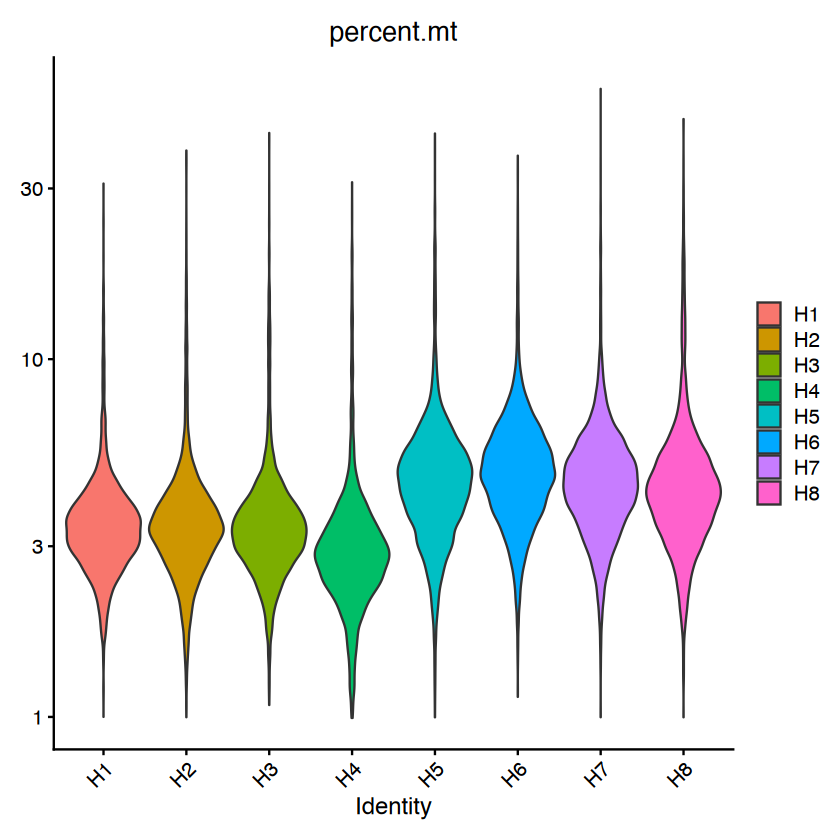

In [7]:
VlnPlot(srat, features = c("percent.mt"),pt.size=0,log=TRUE)

Warning message:
“Default search for "data" layer in "RNA" assay yielded no results; utilizing "counts" layer instead.”


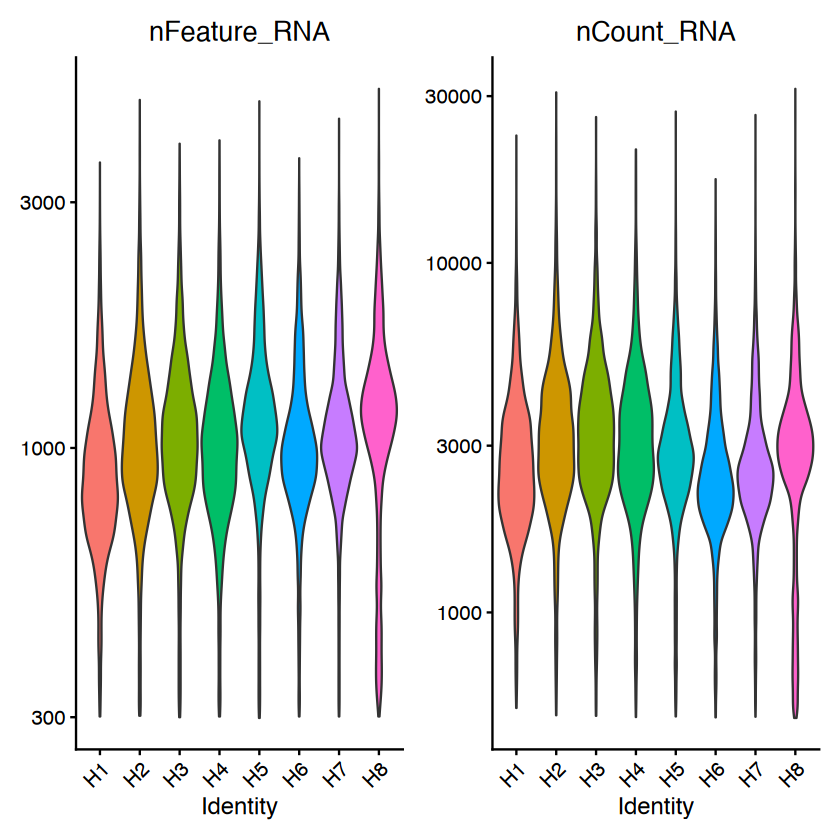

In [8]:
VlnPlot(srat, features = c("nFeature_RNA", "nCount_RNA"), ncol = 2,pt.size=0,log=TRUE)

In [9]:
quantile(srat$nFeature_RNA,0.05)
quantile(srat$nFeature_RNA,0.98)

5% 
536

98% 
2229

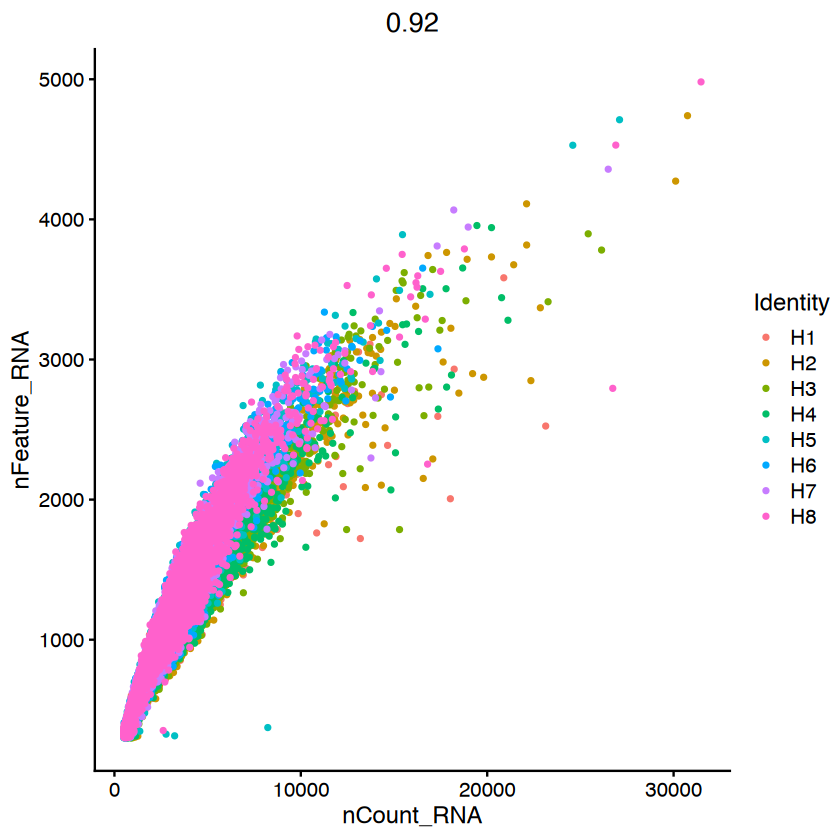

In [10]:
FeatureScatter(srat, feature1 = "nCount_RNA", feature2 = "nFeature_RNA")


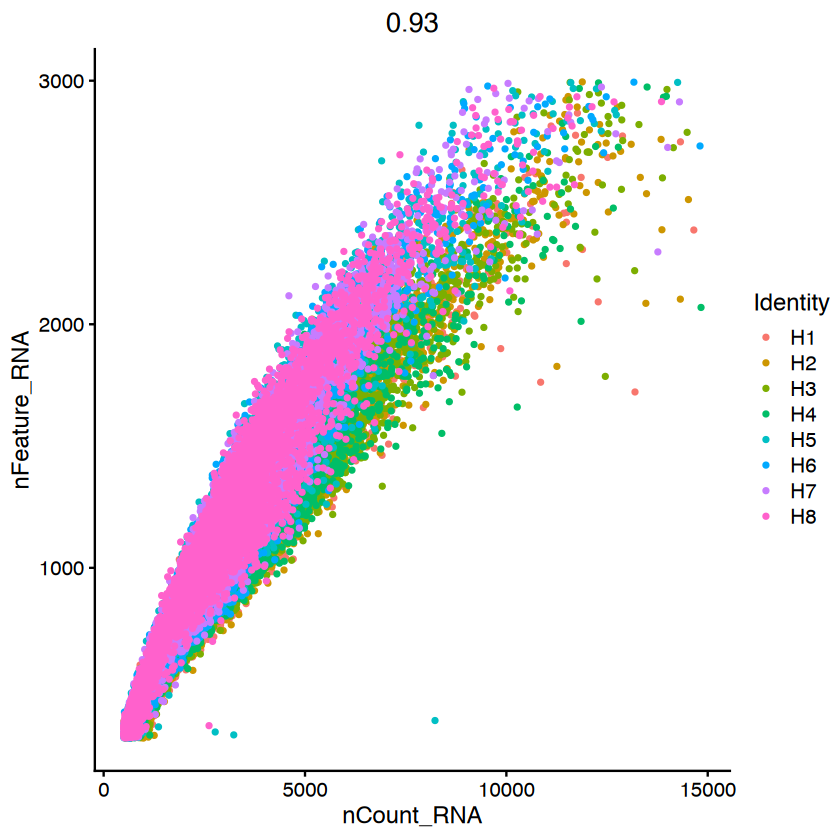

In [11]:
FeatureScatter(subset(srat, subset = nFeature_RNA > 300 & nFeature_RNA < 3000 & nCount_RNA < 15000), feature1 = "nCount_RNA", feature2 = "nFeature_RNA")


In [12]:
srat2 <- subset(srat, subset = nFeature_RNA > 300 & nFeature_RNA < 3000 & nCount_RNA < 15000 & percent.mt < 10)
srat2

An object of class Seurat 
21228 features across 55538 samples within 1 assay 
Active assay: RNA (21228 features, 0 variable features)
 8 layers present: counts.H1.SeuratProject.SeuratProject.SeuratProject.SeuratProject.SeuratProject.SeuratProject, counts.H2.SeuratProject.SeuratProject.SeuratProject.SeuratProject.SeuratProject.SeuratProject, counts.H3.SeuratProject.SeuratProject.SeuratProject.SeuratProject.SeuratProject, counts.H4.SeuratProject.SeuratProject.SeuratProject.SeuratProject, counts.H5.SeuratProject.SeuratProject.SeuratProject, counts.H6.SeuratProject.SeuratProject, counts.H7.SeuratProject, counts.H8

In [14]:
srat = srat2
srat <- NormalizeData(srat, normalization.method = "LogNormalize", scale.factor = 10000,verbose=FALSE)
srat <- FindVariableFeatures(srat, selection.method = "vst", nfeatures = 2000,verbose=FALSE)
srat <- ScaleData(srat, verbose=FALSE)
srat <- RunPCA(srat,verbose=FALSE)


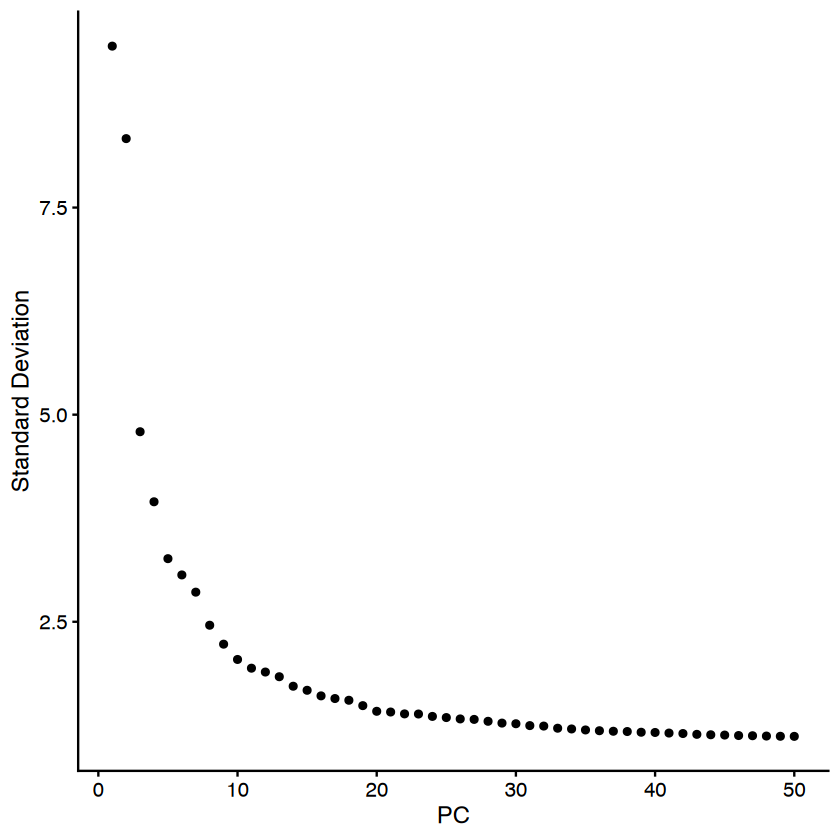

In [15]:
ElbowPlot(srat,50)

In [16]:
srat <- FindNeighbors(srat, dims = 1:20,verbose=FALSE)
srat <- FindClusters(srat, resolution = c(0.1,0.3,0.5,0.7,0.9),verbose=FALSE)
srat <- RunUMAP(srat, dims = 1:20,verbose=FALSE)

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”


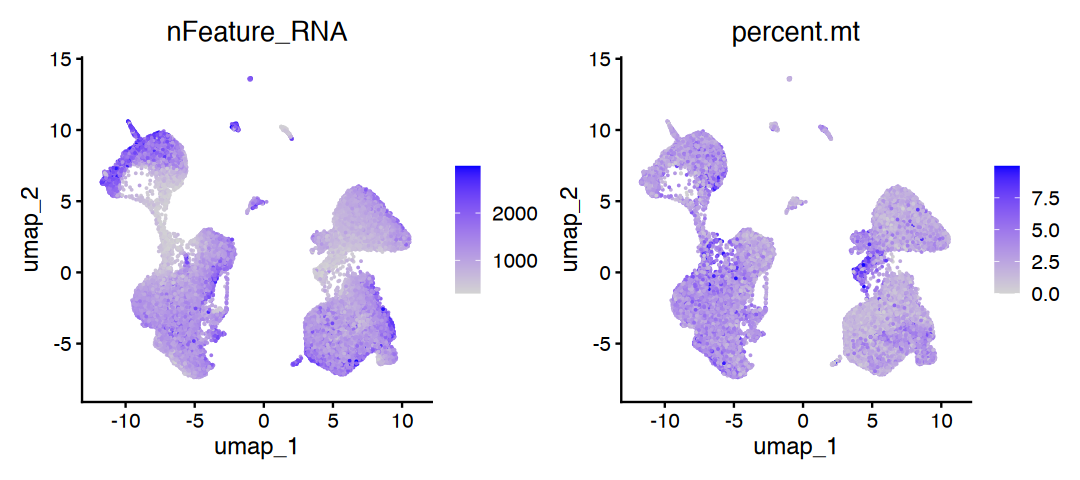

In [19]:
options(repr.plot.width=9, repr.plot.height=4)
FeaturePlot(srat,c('nFeature_RNA','percent.mt'))

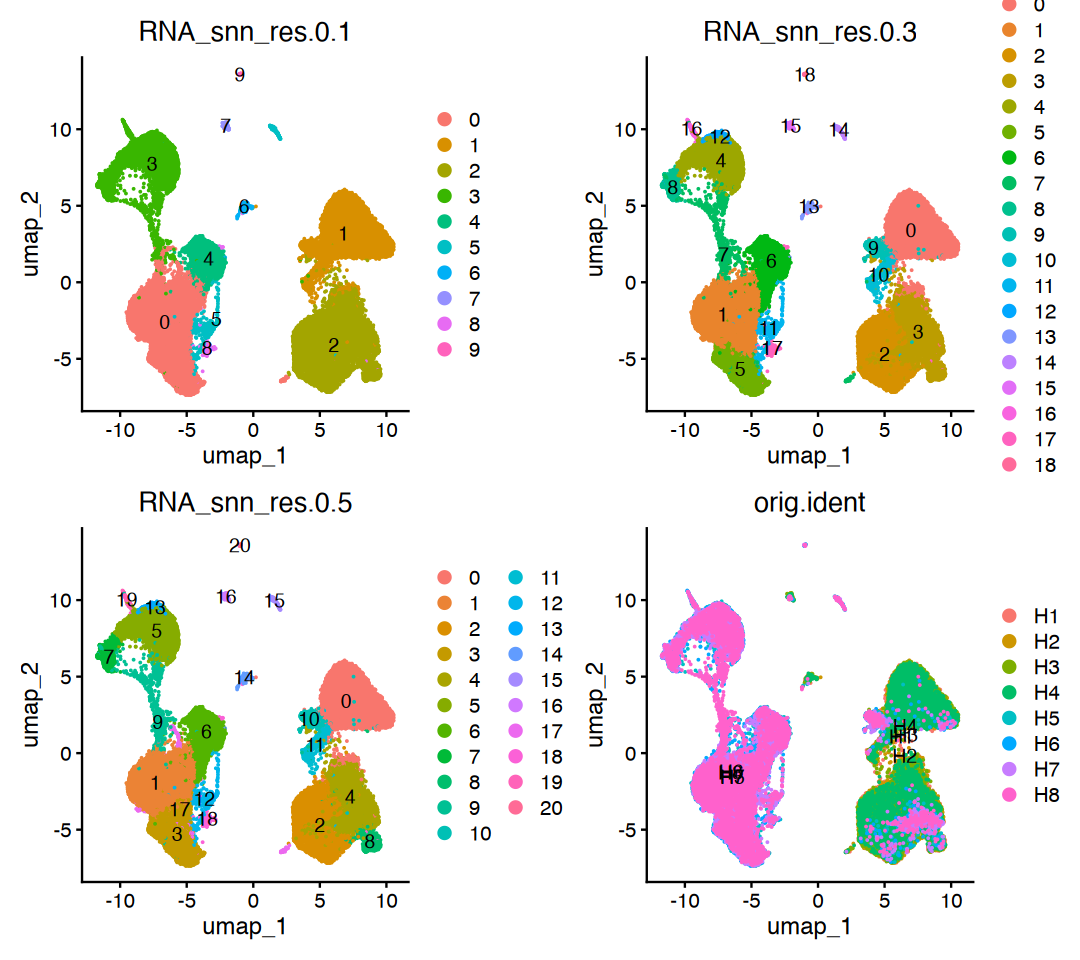

In [17]:
options(repr.plot.width=9, repr.plot.height=8)
DimPlot(srat,ncol=2,group.by=c('RNA_snn_res.0.1','RNA_snn_res.0.3',
                               'RNA_snn_res.0.5','orig.ident'),label=TRUE)

In [27]:
srat[["RNA"]] <- JoinLayers(srat[["RNA"]])

In [47]:
Idents(srat) = 'RNA_snn_res.0.5'
df = FindMarkers(srat,12)
# 9 REMOVE, LYZ and CD3
# 15 and 12 REMOVE, Platelet PPBP
# 16 REMOVE, endothelial cells, SOX4, AIF1, EGFL7
# 18 REMOVE, CD3,NKG7, CD79, IGHM
# 20 pDC JCHAIN, IL3RA, IRF7, TCF4, BCL11A, CLEC4C
# 14 CD7, GATA3, TRDC, KLRB1

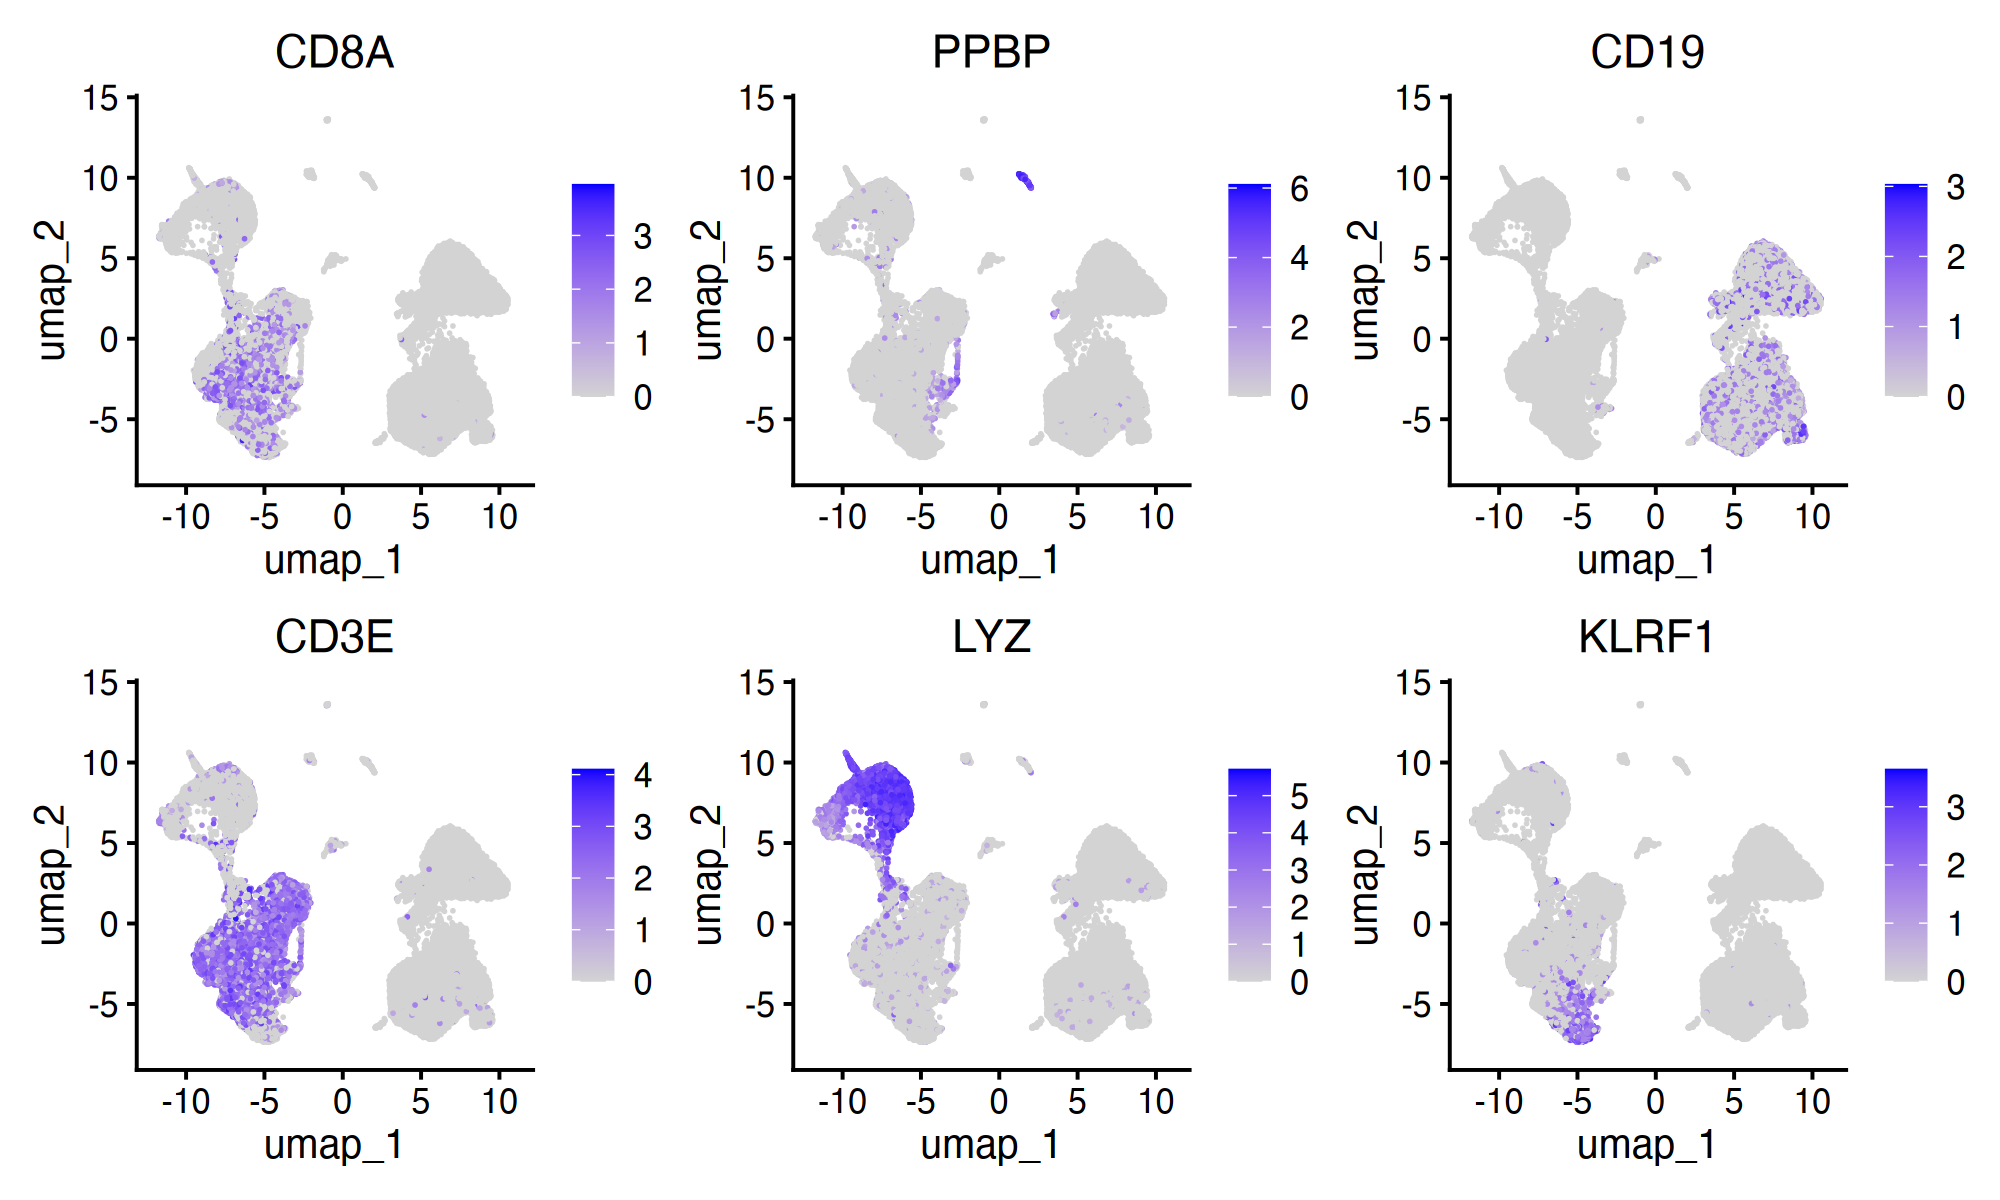

In [34]:
options(repr.plot.width=10, repr.plot.height=6)
FeaturePlot(srat,c('CD8A','PPBP','CD19','CD3E','LYZ','KLRF1'),ncol=3)

In [22]:
saveRDS(srat,'seurat_objects/01_combined_pped_300.RDS') 

In [50]:
srat2 = subset(srat,RNA_snn_res.0.5 %in% c(9,12,15,16,18), invert=TRUE)
srat2
# 9 REMOVE, LYZ and CD3
# 12 and 15 REMOVE, Platelet PPBP
# 16 REMOVE, endothelial cells, SOX4, AIF1, EGFL7
# 18 REMOVE, CD3,NKG7, CD79, IGHM


An object of class Seurat 
21228 features across 53557 samples within 1 assay 
Active assay: RNA (21228 features, 2000 variable features)
 3 layers present: data, counts, scale.data
 2 dimensional reductions calculated: pca, umap

In [51]:
srat2 <- ScaleData(srat2, verbose=FALSE)
srat2 <- RunPCA(srat2,verbose=FALSE)

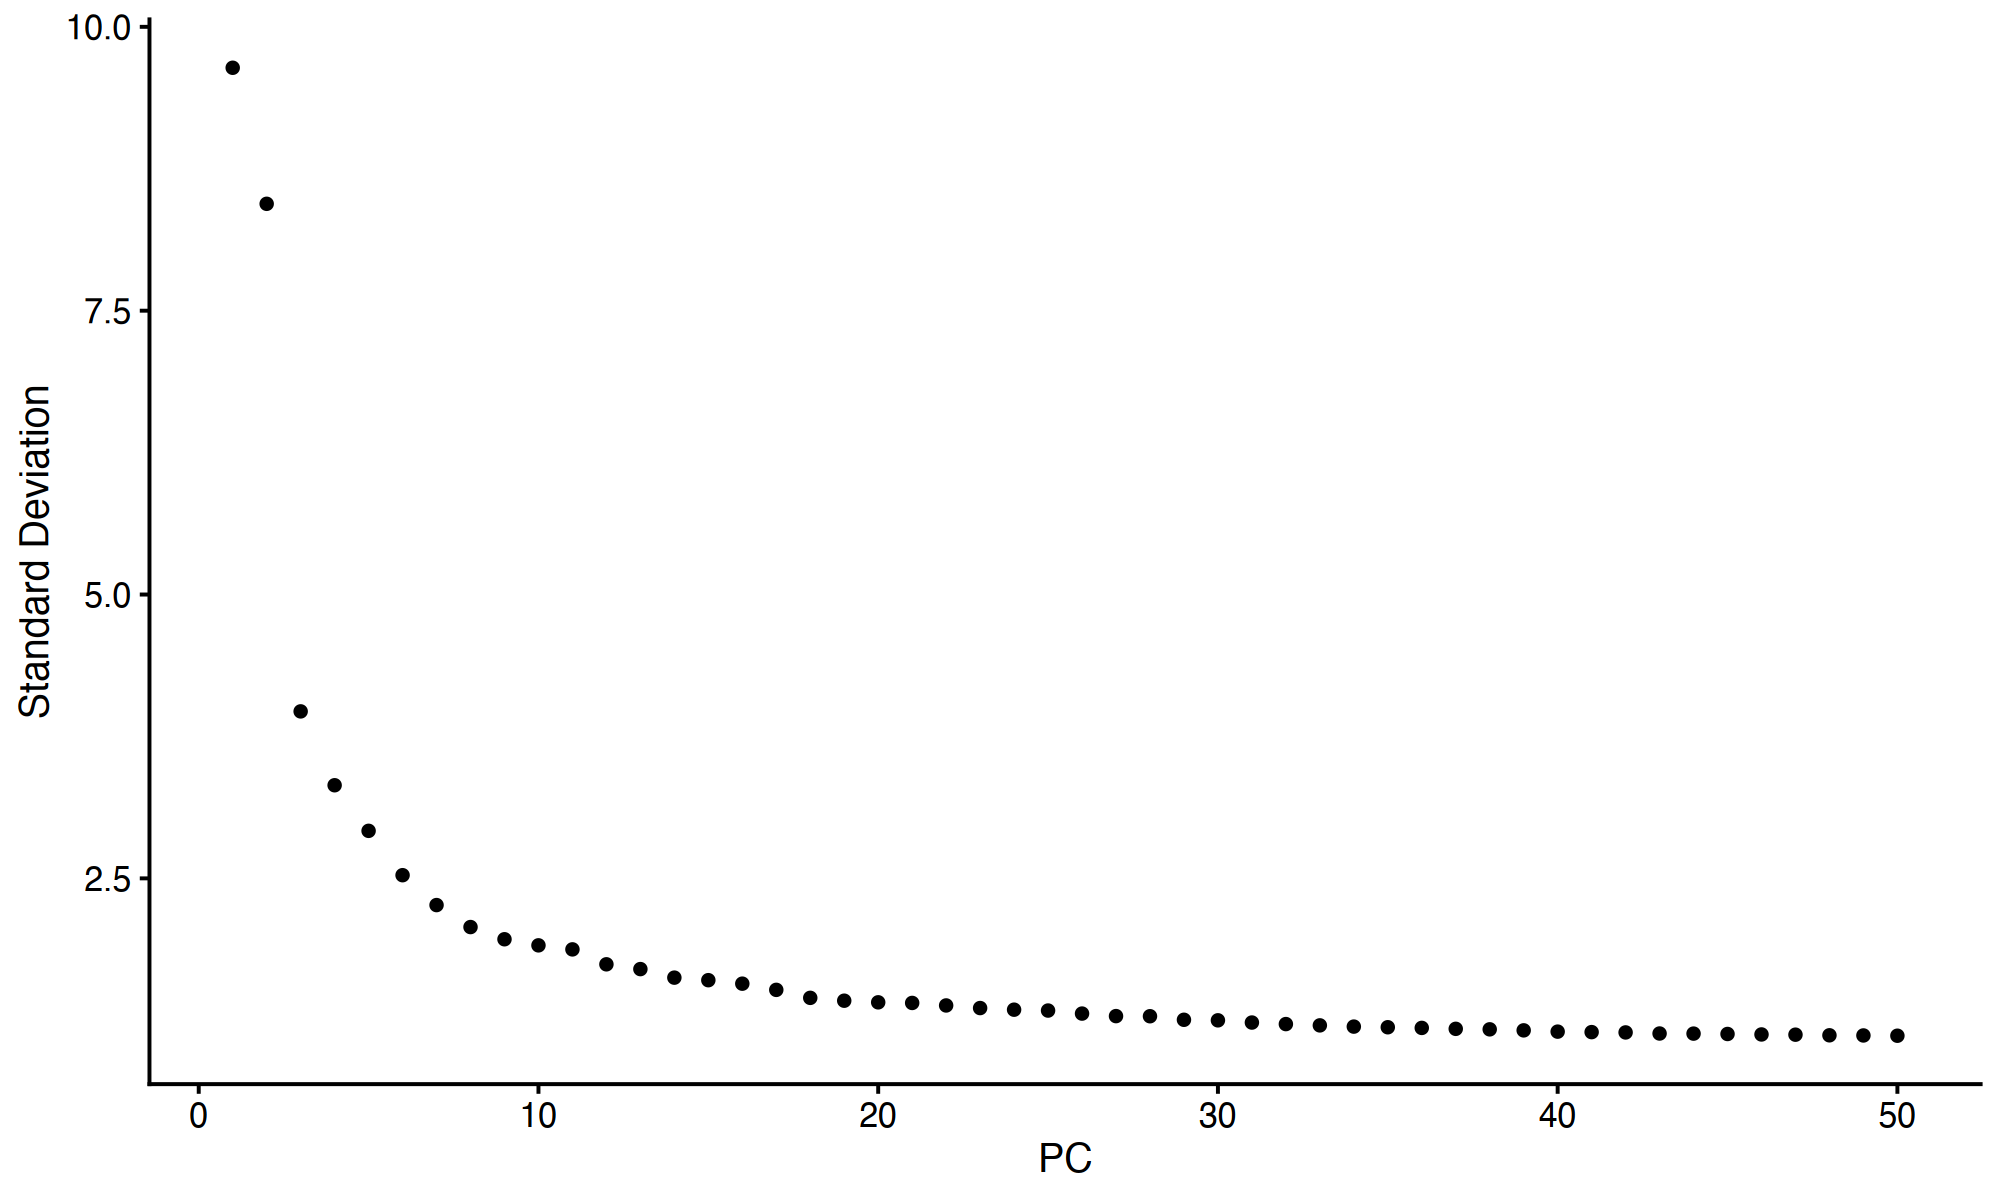

In [52]:
ElbowPlot(srat2,50)

In [53]:
srat2 <- FindNeighbors(srat2, dims = 1:20,verbose=FALSE)
srat2 <- FindClusters(srat2, resolution = c(0.1,0.3,0.5,0.7),verbose=FALSE)
srat2 <- RunUMAP(srat2, dims = 1:20,verbose=FALSE)
srat2 = jz.save.umap.coord(srat2)

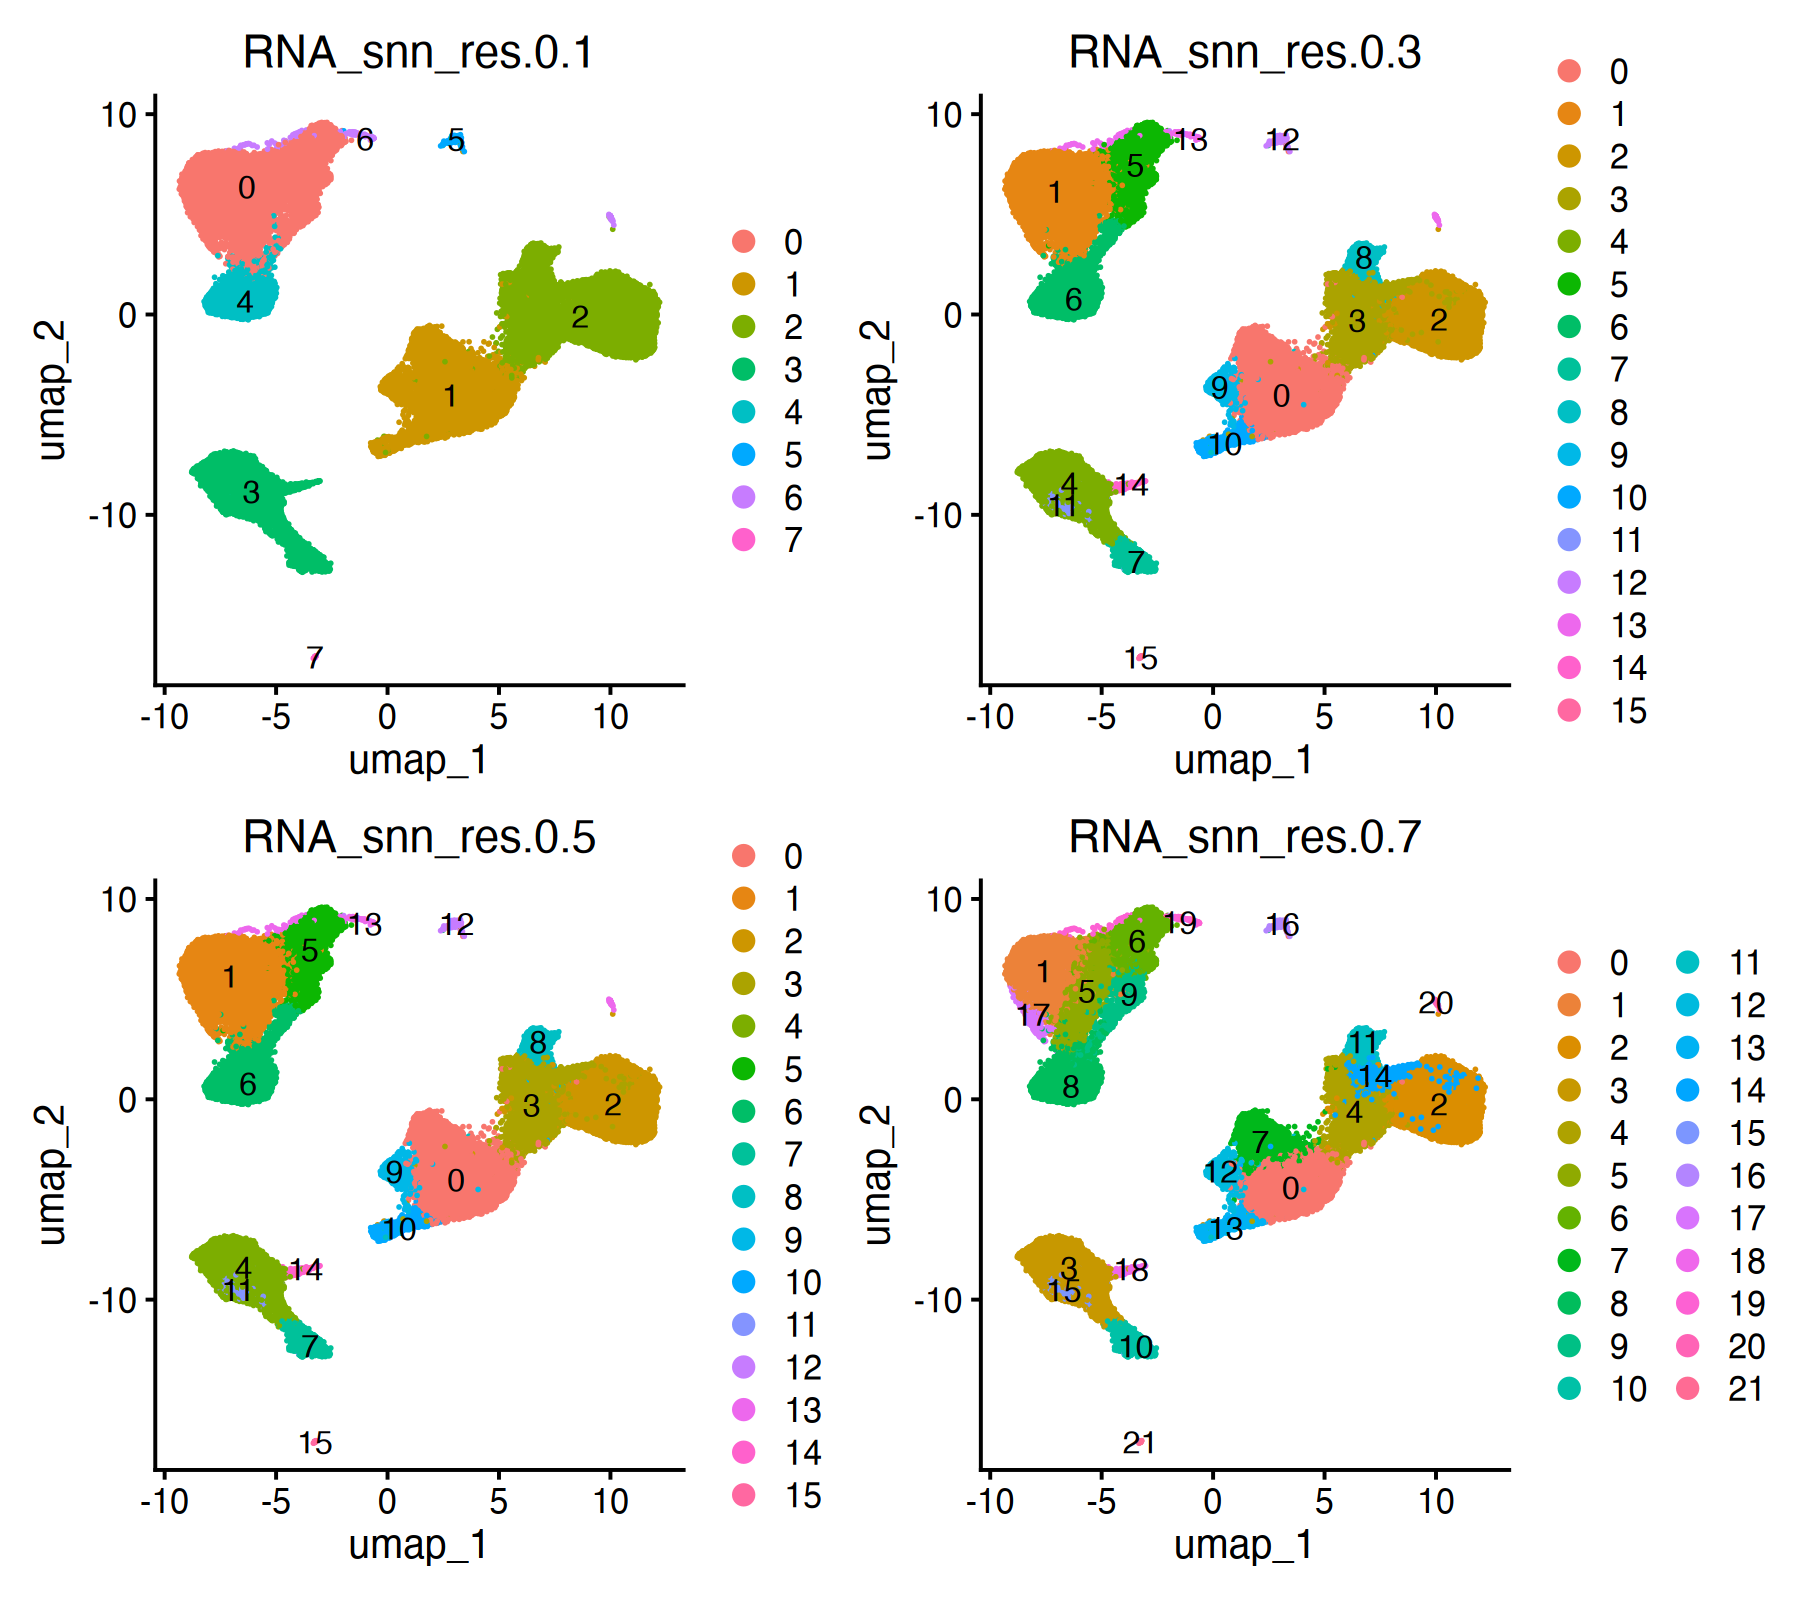

In [54]:
options(repr.plot.width=9, repr.plot.height=8)
DimPlot(srat2,ncol=2,group.by=c('RNA_snn_res.0.1','RNA_snn_res.0.3',
                               'RNA_snn_res.0.5','RNA_snn_res.0.7'),label=TRUE)

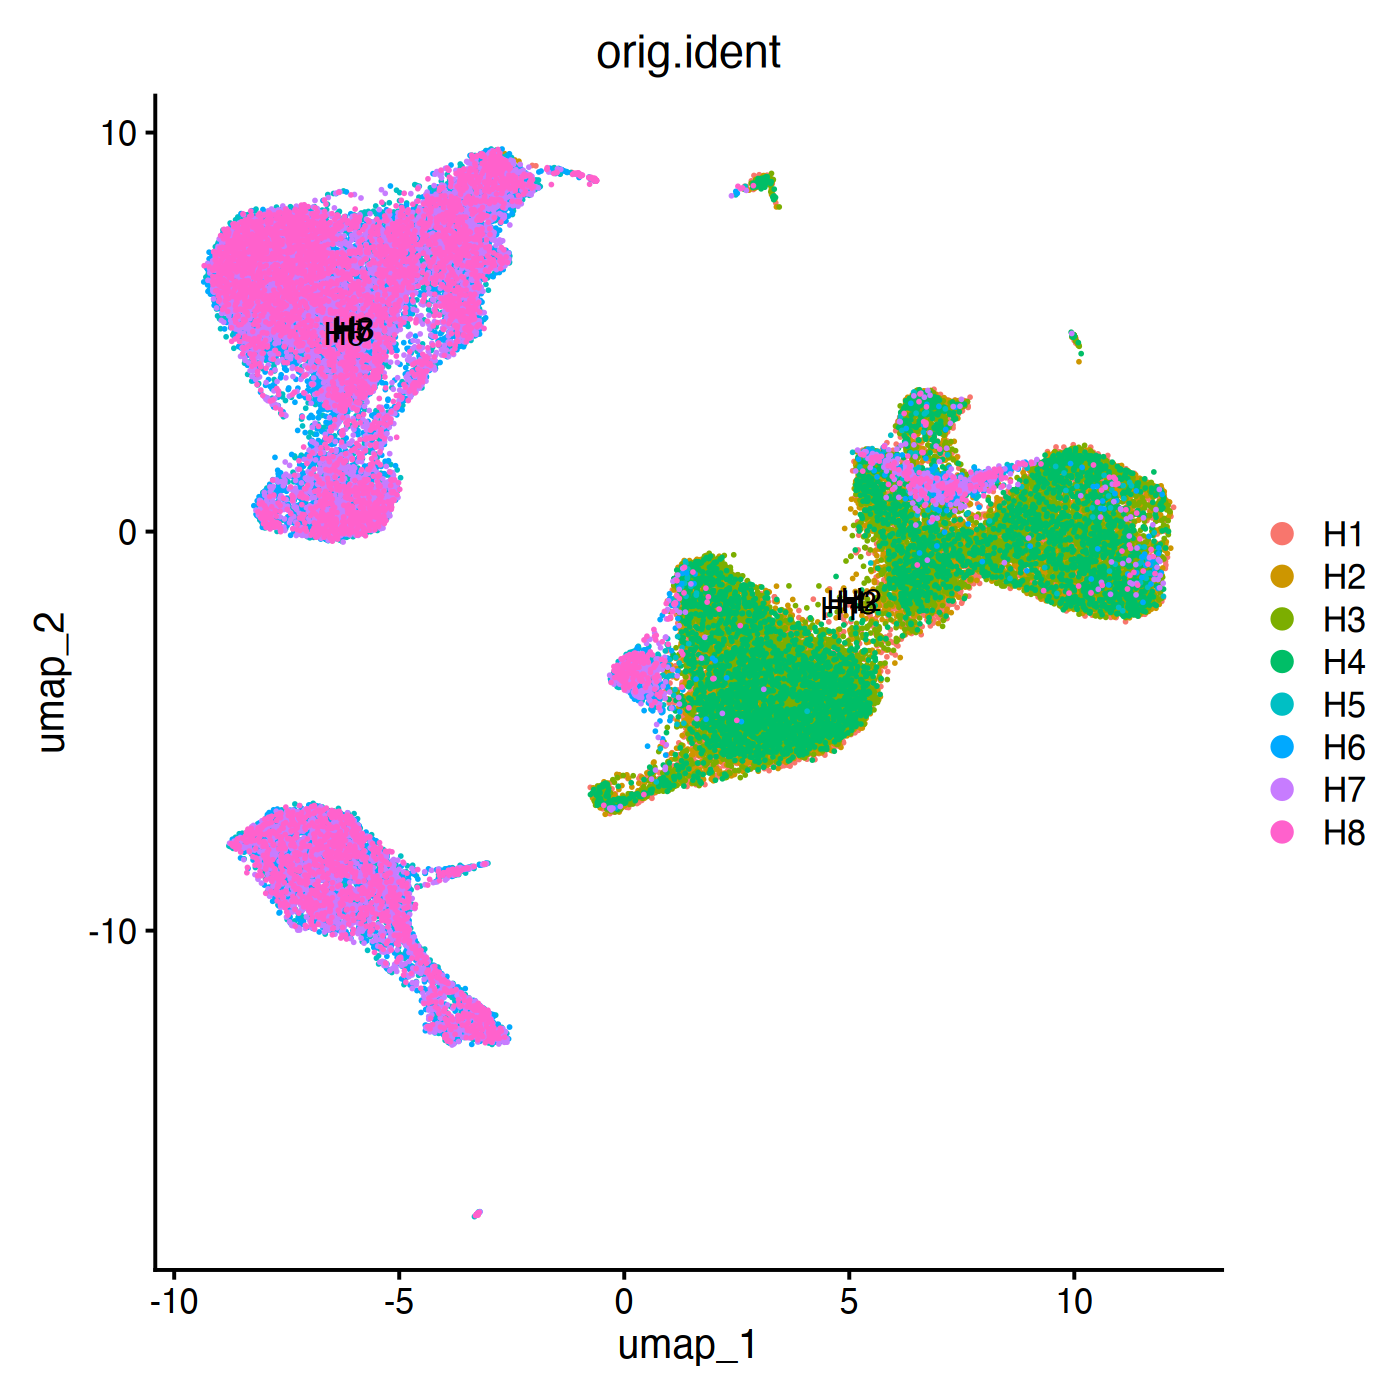

In [55]:
options(repr.plot.width=7, repr.plot.height=7)
DimPlot(srat2,group.by=c('orig.ident'),label=TRUE)

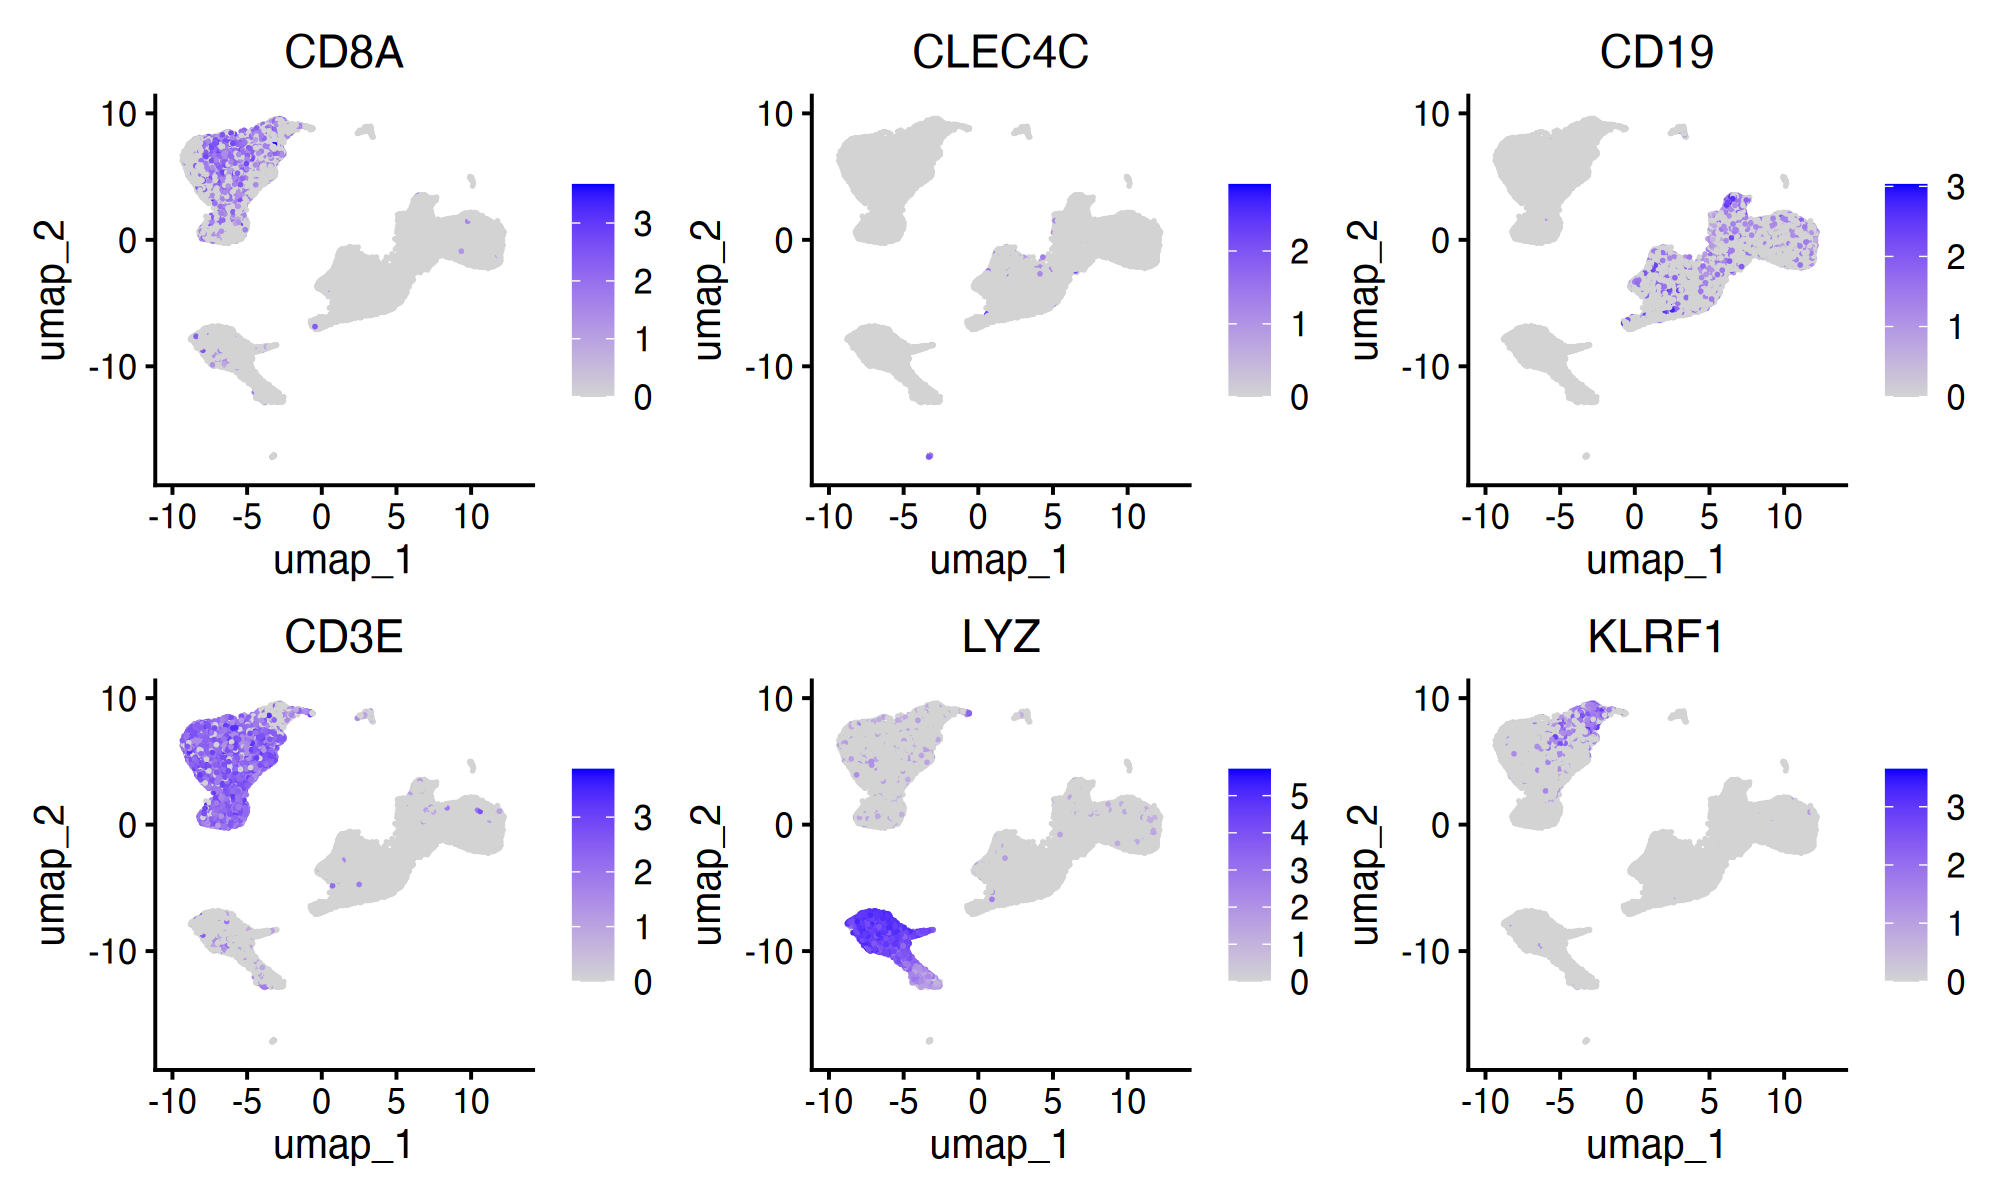

In [61]:
options(repr.plot.width=10, repr.plot.height=6)
FeaturePlot(srat2,c('CD8A','CLEC4C','CD19','CD3E','LYZ','KLRF1'),ncol=3)

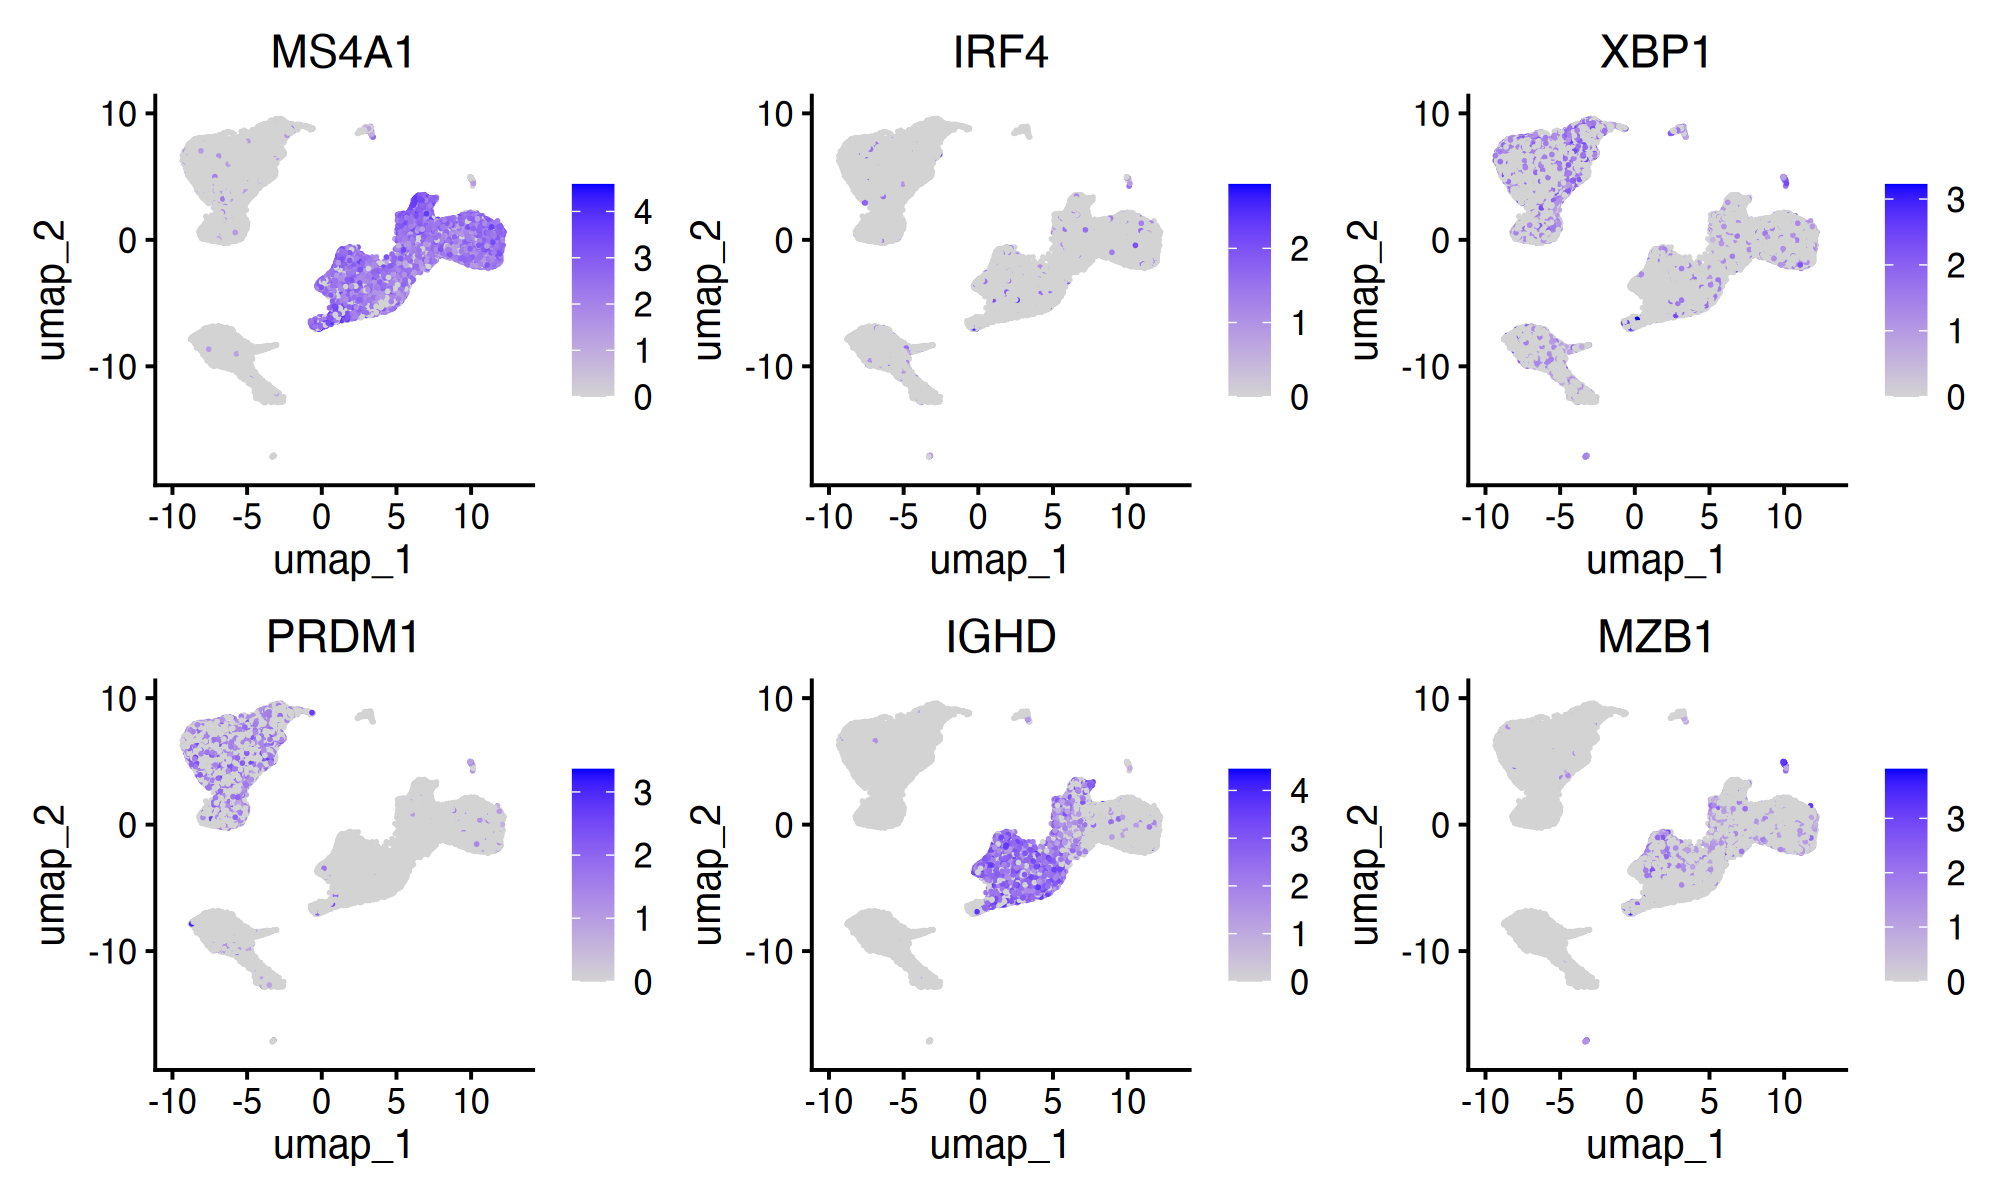

In [60]:
options(repr.plot.width=10, repr.plot.height=6)
FeaturePlot(srat2,c('MS4A1','IRF4','XBP1','PRDM1','IGHD','MZB1'),ncol=3)

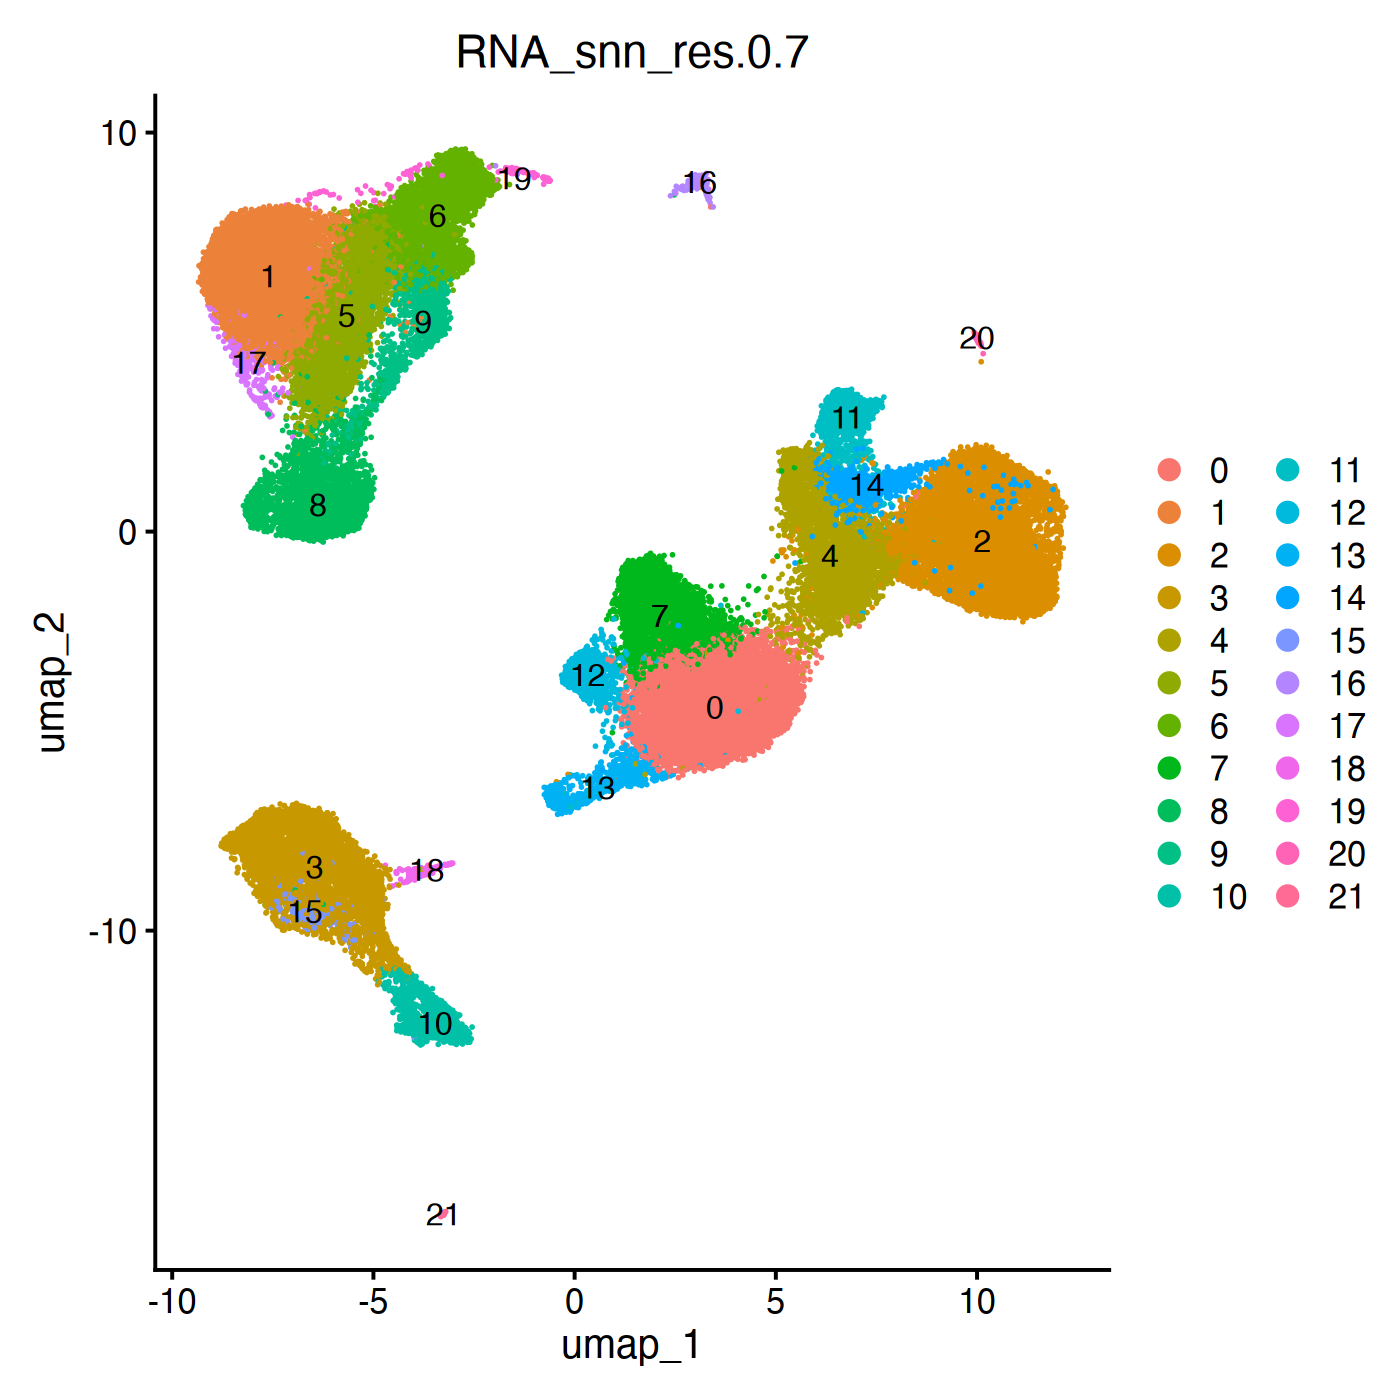

In [59]:
options(repr.plot.width=7, repr.plot.height=7)
DimPlot(srat2,group.by=c('RNA_snn_res.0.7'),label=TRUE)

In [68]:
Idents(srat2) = 'RNA_snn_res.0.7'
df = FindMarkers(srat2,19)
#df %>% filter(avg_log2FC>0) %>% arrange(desc(pct.1-pct.2)) %>% head(40)
# 20 PB
# 16 IL7R CD7 GATA3 TRDC

In [77]:
srat2$celltype = as.character(srat2$RNA_snn_res.0.7)
srat2$celltype[srat2$celltype %in% c(3,10,15,18)] = 'Myeloid'
srat2$celltype[srat2$celltype %in% c(1,5,8,9,16,17)] = 'T cell'
srat2$celltype[srat2$celltype %in% c(6,19)] = 'NK'
srat2$celltype[srat2$celltype %in% c(0,7,12,13,4,11)] = 'Naive B cell'
srat2$celltype[srat2$celltype %in% c(2,14)] = 'Memory B cell'
srat2$celltype[srat2$celltype %in% c(20)] = 'Plasmablast'
srat2$celltype[srat2$celltype %in% c(21)] = 'pDC'

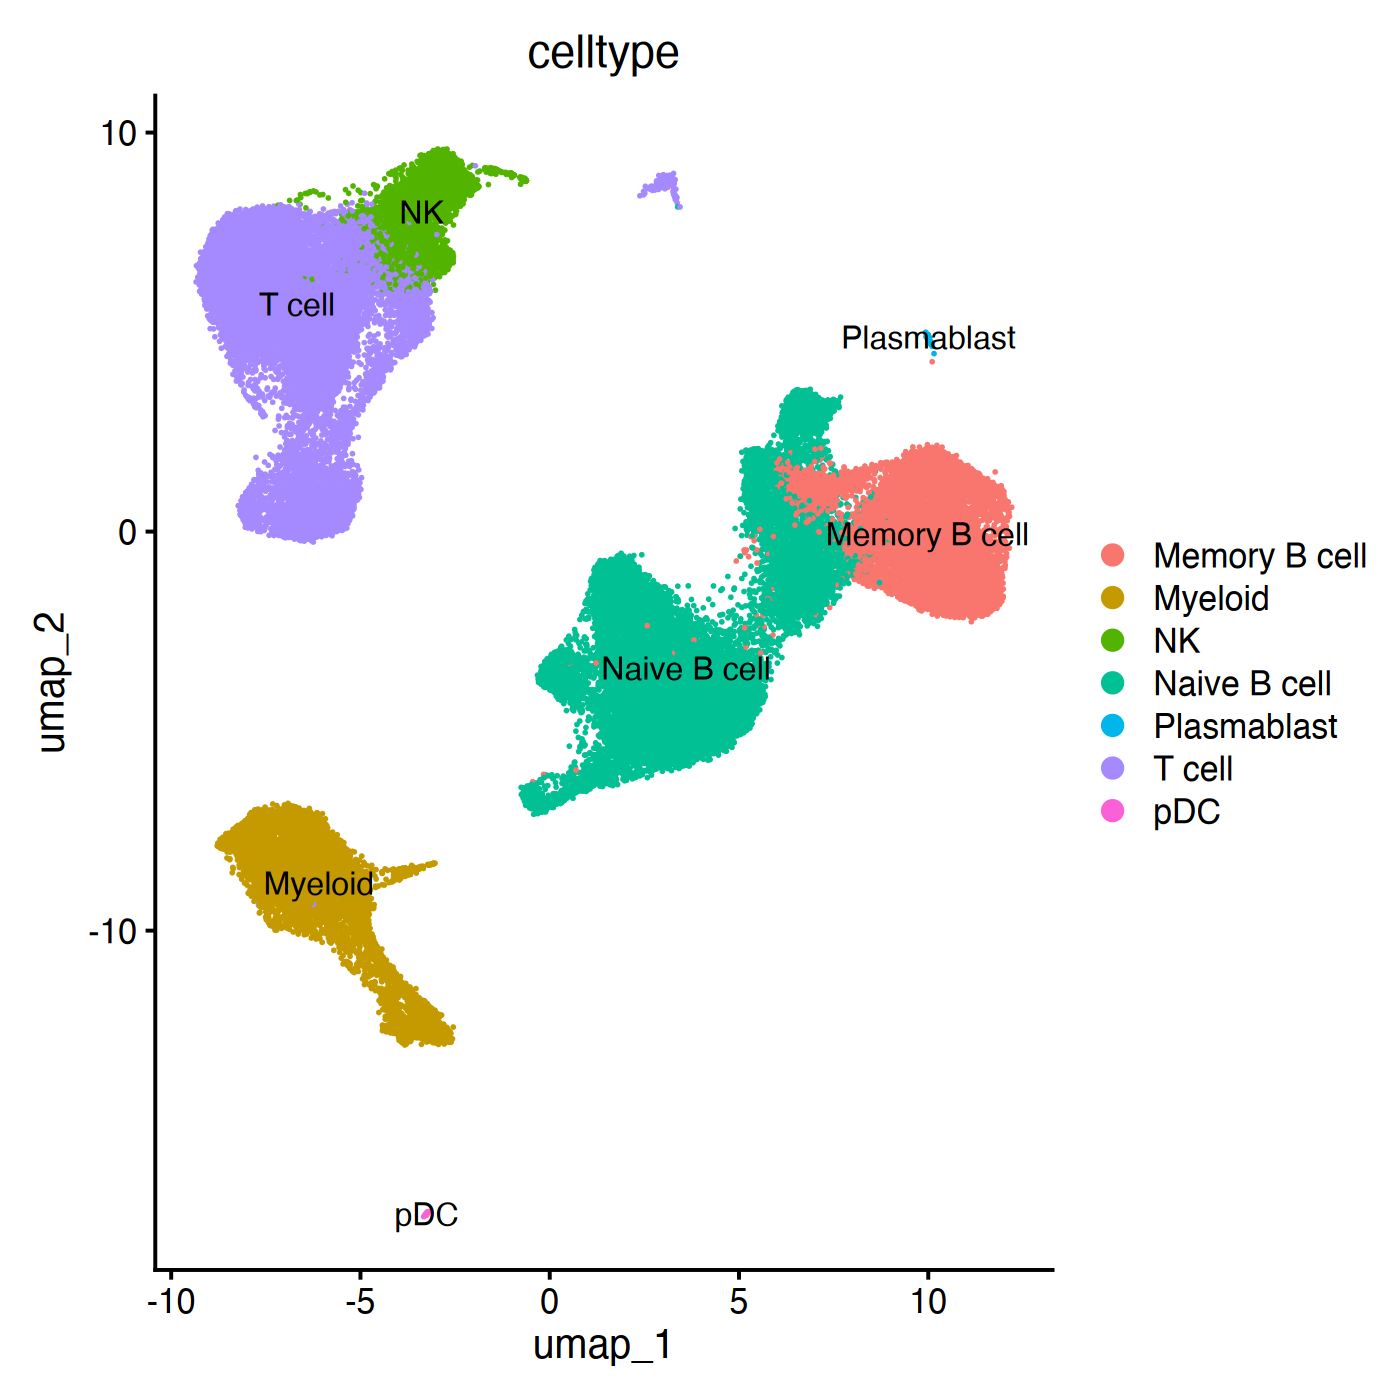

In [78]:
options(repr.plot.width=7, repr.plot.height=7)
DimPlot(srat2,group.by=c('celltype'),label=TRUE)

In [79]:
saveRDS(srat2,'seurat_objects/02_celltype_labeled_300.RDS')

In [80]:
bcell = subset(srat2,celltype %in% c('Memory B cell','Naive B cell','Plasmablast'))
bcell

An object of class Seurat 
21228 features across 27500 samples within 1 assay 
Active assay: RNA (21228 features, 2000 variable features)
 3 layers present: data, counts, scale.data
 2 dimensional reductions calculated: pca, umap

In [81]:
bcell <- ScaleData(bcell, vars.to.regress = c('percent.mt','nFeature_RNA'), verbose=FALSE)
bcell <- RunPCA(bcell,verbose=FALSE)
bcell <- FindNeighbors(bcell, dims = 1:20,verbose=FALSE)
bcell <- FindClusters(bcell, resolution = c(0.1,0.3,0.5,0.7),verbose=FALSE)
bcell <- RunUMAP(bcell, dims = 1:20,verbose=FALSE)
bcell = jz.save.umap.coord(bcell)

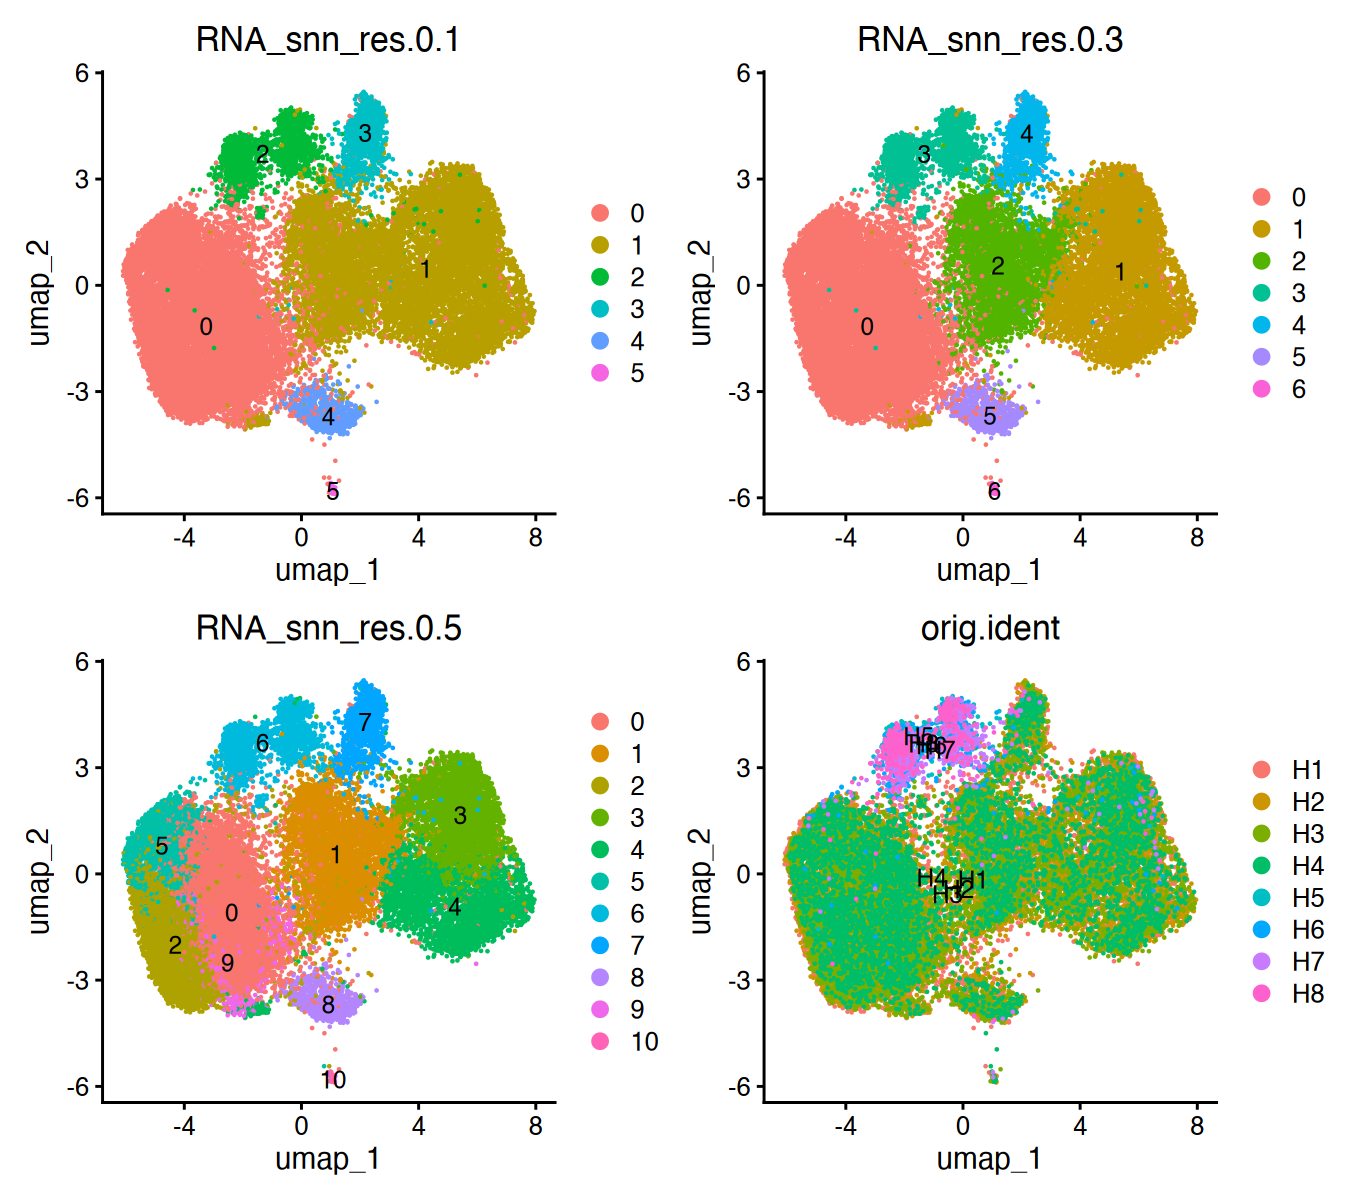

In [96]:
options(repr.plot.width=9, repr.plot.height=8,repr.plot.res=150)
DimPlot(bcell,ncol=2,group.by=c('RNA_snn_res.0.1','RNA_snn_res.0.3',
                               'RNA_snn_res.0.5','orig.ident'),label=TRUE)

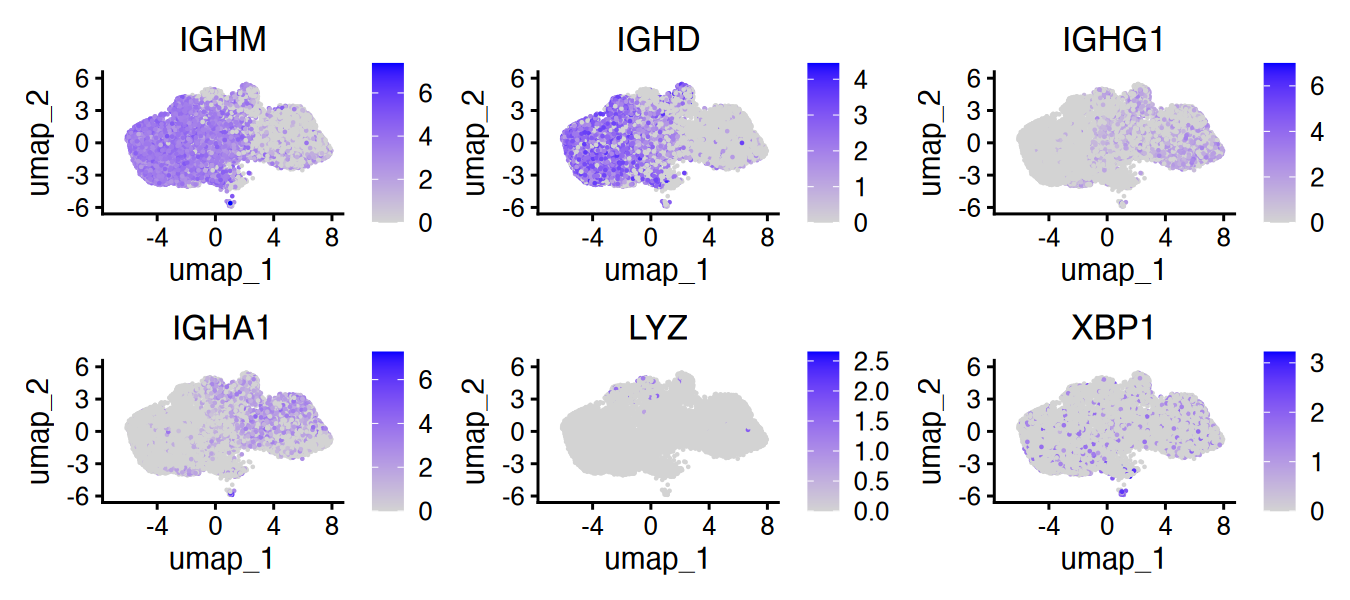

In [95]:
options(repr.plot.width=9, repr.plot.height=4,repr.plot.res=150)
FeaturePlot(bcell,c('IGHM','IGHD','IGHG1','IGHA1','LYZ','XBP1'),ncol=3)

In [86]:
Idents(bcell) = 'RNA_snn_res.0.1'
df = FindMarkers(bcell,2) # NKG7, LYZ, GZMH, CCL5
#df %>% filter(avg_log2FC>0,p_val_adj<1e-50) %>% arrange(desc(pct.1-pct.2)) %>% head(40)

In [89]:
bcell$bcelltype = as.character(bcell$RNA_snn_res.0.3)
bcell$bcelltype[bcell$bcelltype %in% c(0,2,4,5)] = 'Naive B cell'
bcell$bcelltype[bcell$bcelltype %in% c(1)] = 'Memory B cell'
bcell$bcelltype[bcell$bcelltype %in% c(3)] = 'Doublets'
bcell$bcelltype[bcell$bcelltype %in% c(6)] = 'Plasmablast'

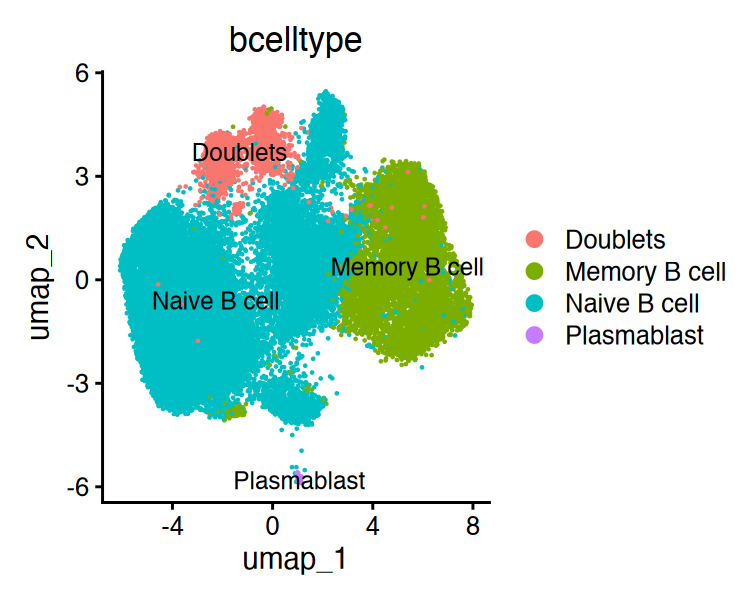

In [93]:
options(repr.plot.width=5, repr.plot.height=4,repr.plot.res=150)
DimPlot(bcell,group.by=c('bcelltype'),label=TRUE)

In [99]:
srat2$cell.id = rownames(srat2@meta.data)
bcell$cell.id = rownames(bcell@meta.data)

In [100]:
srat2$celltype[srat2$cell.id %in% bcell$cell.id] = bcell$bcelltype

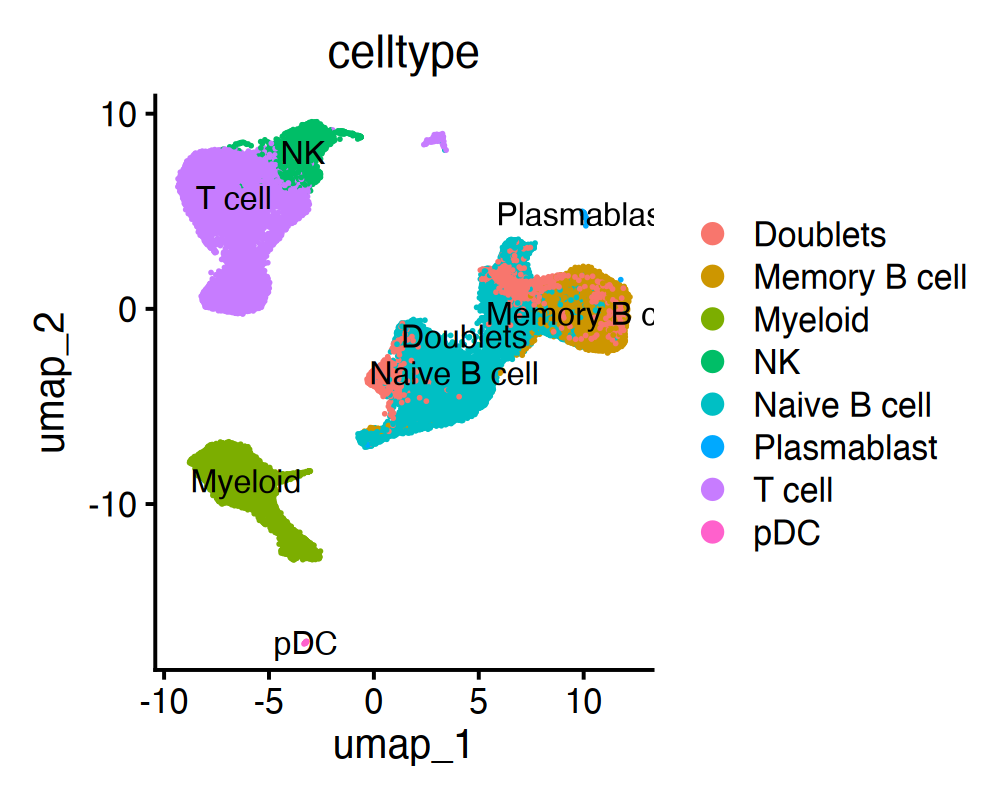

In [104]:
options(repr.plot.width=5, repr.plot.height=4,repr.plot.res=200)
DimPlot(srat2,group.by='celltype',label=TRUE)

In [105]:
srat3 = subset(srat2,celltype!='Doublets')
srat3

An object of class Seurat 
21228 features across 51751 samples within 1 assay 
Active assay: RNA (21228 features, 2000 variable features)
 3 layers present: data, counts, scale.data
 2 dimensional reductions calculated: pca, umap

In [107]:
srat3 <- ScaleData(srat3, vars.to.regress = c('percent.mt','nFeature_RNA'), verbose=FALSE)
srat3 <- RunPCA(srat3,verbose=FALSE)
srat3 <- FindNeighbors(srat3, dims = 1:20,verbose=FALSE)
srat3 <- FindClusters(srat3, resolution = c(0.1,0.3,0.5,0.7),verbose=FALSE)
srat3 <- RunUMAP(srat3, n.neighbors=50, dims = 1:50,min.dist = 0.5,verbose=FALSE)
srat3 = jz.save.umap.coord(srat3)

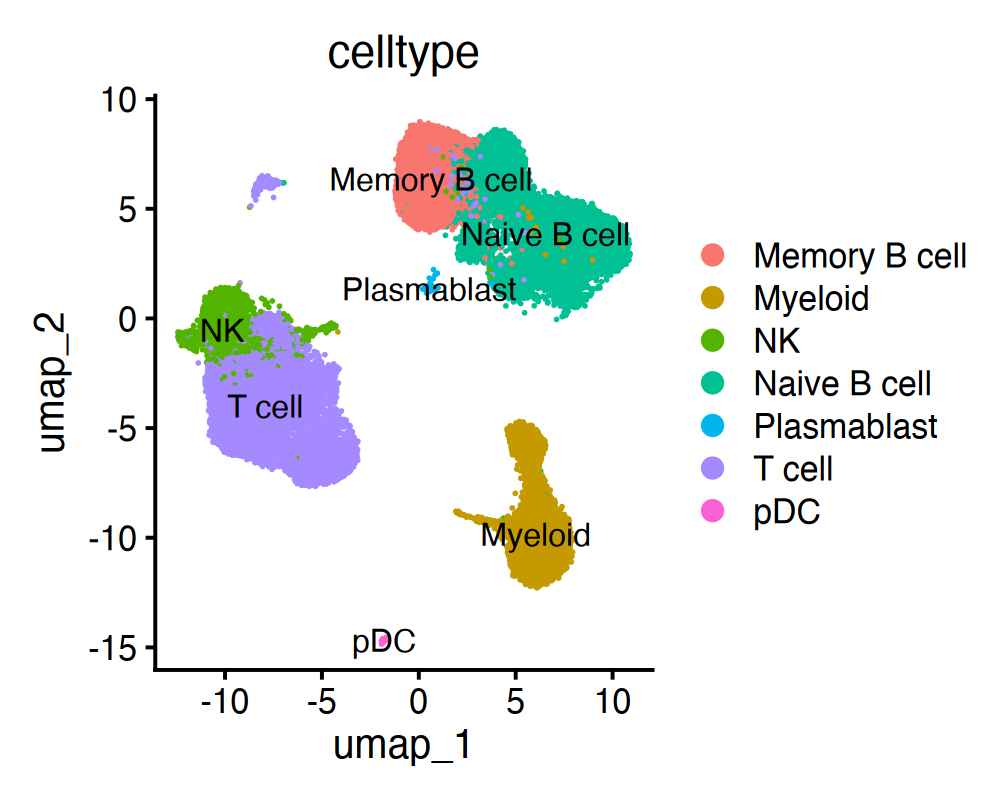

In [114]:
options(repr.plot.width=5, repr.plot.height=4,repr.plot.res=200)
DimPlot(srat3,group.by='celltype',label=TRUE) 

In [115]:
srat3$bcelltype = srat3$celltype 
srat3$bcelltype[srat3$bcelltype %in% c('Myeloid','NK','T cell','pDC')] = 'Non-B cell'

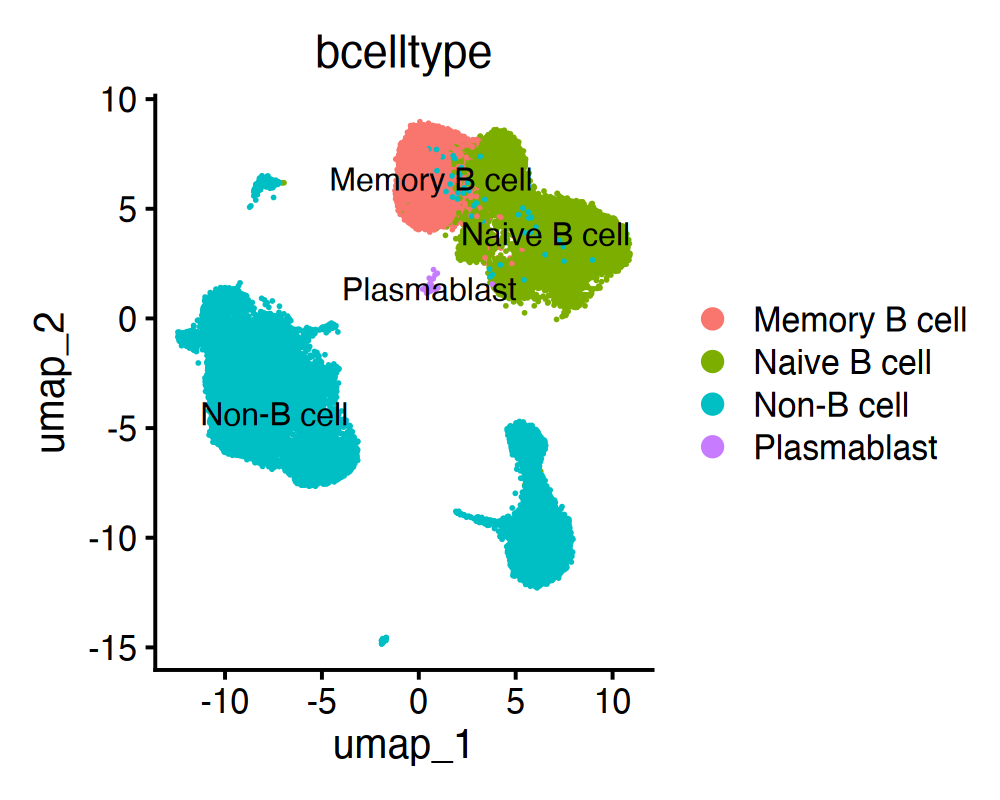

In [117]:
options(repr.plot.width=5, repr.plot.height=4,repr.plot.res=200)
DimPlot(srat3,group.by='bcelltype',label=TRUE) 

In [5]:
saveRDS(srat3,'seurat_objects/03_cellphenotype_labeled_300.RDS')